# Classification

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import (confusion_matrix, classification_report, RocCurveDisplay, roc_auc_score, 
accuracy_score, precision_score, recall_score, f1_score, auc, precision_recall_curve, average_precision_score)

from sklearn.decomposition import PCA
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from imblearn.over_sampling import SMOTE

pd.set_option('display.max_rows', 500)

In [2]:
# Import datasets
df_patient = pd.read_excel('data/Descriptif_patients_modified.xlsx')
init_df_radiomics_multislices = pd.read_excel('data/radiomiques_multislice.xlsx')
classe_name_mapping = {
    'CCK': 0,
    'CHC': 1,
    'Mixtes': 2
}
init_df_radiomics_multislices['classe_name'] = init_df_radiomics_multislices['classe_name'].map(classe_name_mapping)
init_df_radiomics_multislices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9404 entries, 0 to 9403
Columns: 135 entries, slice_num to original_ngtdm_Strength
dtypes: datetime64[ns](3), float64(123), int64(3), object(6)
memory usage: 9.7+ MB


In [3]:
df_patient['dead_after_one_year'] = df_patient['dead_after_one_year'].astype('int64')
df_patient['dead_after_six_year'] = df_patient['dead_after_six_year'].astype('int64')
df_patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   classe_name          147 non-null    int64  
 1   patient_num          147 non-null    int64  
 2   Gender               145 non-null    float64
 3   Age_at_disease       142 non-null    float64
 4   Alpha_foetoprotein   113 non-null    float64
 5   dead_after_one_year  147 non-null    int64  
 6   dead_after_six_year  147 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 8.2 KB


In [4]:
data_init= pd.merge(init_df_radiomics_multislices, df_patient, on=['classe_name','patient_num'], how='left')
data_n = data_init.select_dtypes(include=['float64','int64'])
data_del = data_init.select_dtypes(include=['datetime64','object'])
#data = init_df_radiomics.select_dtypes(include=['number'])
data = data_n.T.drop_duplicates().T
data = data_n.dropna(axis=1, how='all')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9404 entries, 0 to 9403
Columns: 129 entries, slice_num to dead_after_six_year
dtypes: float64(124), int64(5)
memory usage: 9.3 MB


In [5]:
data.head()

,slice_num,classe_name,patient_num,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,...,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,Gender,Age_at_disease,Alpha_foetoprotein,dead_after_one_year,dead_after_six_year
0,54.0,0,1,405.8,784.6,108013119.0,4.423730,236.5,2.044339,890.0,...,0.141803,0.031819,481.985606,0.238792,6.686087,1.0,NaN,NaN,0,0
1,55.0,0,1,374.6,877.0,217855694.0,4.842085,295.5,2.146068,1052.0,...,0.070190,0.025677,972.510179,0.200256,10.582781,1.0,NaN,NaN,0,0
2,56.0,0,1,350.0,909.7,316932436.0,5.024121,356.0,2.095717,1123.0,...,0.075007,0.019048,1318.449846,0.241414,9.740356,1.0,NaN,NaN,0,0
3,57.0,0,1,318.6,946.4,342297374.0,5.179079,400.0,2.042928,1216.0,...,0.076645,0.019024,1537.946771,0.262199,11.378192,1.0,NaN,NaN,0,0
4,58.0,0,1,292.0,954.7,380468266.0,5.255932,445.0,2.011028,1271.0,...,0.064824,0.018696,1834.491369,0.236669,13.638704,1.0,NaN,NaN,0,0


In [6]:
X_init = data.drop(columns=['dead_after_one_year', 'dead_after_six_year','patient_num'])
imp = IterativeImputer(max_iter=10, random_state=42)
df_imputed = imp.fit_transform(X_init)
original_columns = X_init.columns.tolist()
X = pd.DataFrame(df_imputed, columns=range(1, len(X_init.columns) + 1))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=range(1, len(X_init.columns) + 1),index=X_init.index)

In [7]:
X_original_col = pd.DataFrame(X_scaled, columns=original_columns,index=X_init.index)

In [8]:
X_original_col.info()
X_original_col.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9404 entries, 0 to 9403
Columns: 126 entries, slice_num to Alpha_foetoprotein
dtypes: float64(126)
memory usage: 9.0 MB


,slice_num,classe_name,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,...,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,Gender,Age_at_disease,Alpha_foetoprotein
0,0.453070,-1.791657,0.791629,1.259224,0.008447,1.869461,2.349247,-0.941129,1.045312,1.889752,...,1.969407,-0.725214,-0.179417,-0.043793,0.220729,0.877464,0.434258,1.500707,-0.104423,0.466654
1,0.507970,-1.791657,0.663220,1.523220,0.388571,2.293996,3.171400,-0.882843,1.424956,2.698872,...,1.924235,-0.726340,-0.186614,-0.043793,0.687322,0.682201,0.865397,1.500707,-0.778604,1.247950
2,0.562871,-1.791657,0.561975,1.616648,0.731438,2.478721,4.014454,-0.911692,1.591343,3.352463,...,1.899030,-0.722197,-0.186129,-0.043793,1.016384,0.890751,0.772189,1.500707,-1.106407,1.613631
3,0.617772,-1.791657,0.432743,1.721503,0.819216,2.635969,4.627585,-0.941937,1.809287,3.842823,...,1.874620,-0.719494,-0.185965,-0.043793,1.225173,0.996066,0.953403,1.500707,-1.224693,1.692038
4,0.672672,-1.791657,0.323266,1.745217,0.951311,2.713957,5.254650,-0.960215,1.938178,4.100871,...,1.944358,-0.722507,-0.187153,-0.043793,1.507250,0.866708,1.203511,1.500707,-1.079539,1.935999


In [9]:
data['patient_num'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 9404 entries, 0 to 9403
Series name: patient_num
Non-Null Count  Dtype
--------------  -----
9404 non-null   int64
dtypes: int64(1)
memory usage: 73.6 KB


## PCA

### PCA One Year

In [10]:
y = data['dead_after_one_year']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train)
X_test_selected_df = pca.transform(X_test)

X_train_SMOTE, y_train_SMOTE = X_train, y_train 

#smote = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#### Model Preparation

In [12]:
# Instiantiate models
models = {'lr': LogisticRegression(max_iter=5_000, random_state=42, solver='saga'),
          'rf': RandomForestClassifier(random_state=42),
          'gb': GradientBoostingClassifier(random_state=42),
          'dt': DecisionTreeClassifier(random_state=42),
          'et': ExtraTreesClassifier(random_state=42),
          'ada': AdaBoostClassifier(random_state=42),
          'svc': SVC(random_state=42, probability=True),
          'xgb': xgb.XGBClassifier(random_state=42)
        }

In [13]:
# Instantiate lists to store results
init_list = []
gs_list = []

# Function to run model -- input scaler and model
def run_model(mod, mod_params={}, grid_search=False, mission = 'After one year'):
    
    # Initial dictionary to hold model results
    results = {}
    
    pipe = Pipeline([
            (mod, models[mod])
            ])
    
    if grid_search:
        # Instantiate list to store gridsearch results
        gs = GridSearchCV(pipe, param_grid=mod_params, cv=3, verbose=1, scoring='roc_auc', n_jobs=-1)
        gs.fit(X_train_SMOTE, y_train_SMOTE)
        pipe = gs
        
    else:
        pipe.fit(X_train_SMOTE, y_train_SMOTE)
    

    # Retrieve metrics
    predictions = pipe.predict(X_test_selected_df)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    y_test_pred_prob = pipe.predict_proba(X_test_selected_df)[:,1]
    y_train_pred_prob = pipe.predict_proba(X_train_SMOTE)[:,1]


    results['model'] = mod
    results['mission'] = mission
    results['train_auc'] = roc_auc_score(y_train_SMOTE, y_train_pred_prob)
    results['test_auc'] = roc_auc_score(y_test, y_test_pred_prob)
    results['precision'] = precision_score(y_test, predictions)
    results['specificity'] = tn / (tn + fp)
    results['recall'] = recall_score(y_test, predictions)
    results['f_score'] = f1_score(y_test, predictions)

    if grid_search:
        gs_list.append(results)
        print('### BEST PARAMS ###')
        display(pipe.best_params_)
        
    else:
        init_list.append(results)
    
    print('### METRICS ###')
    display(results)
    
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    
    return pipe

In [14]:
def roc_curve_plotter(model_dict, plot_top=False):
    fig, ax = plt.subplots(1, 1, figsize=(12,10))
    axes = {}
    for i, m in enumerate(model_dict.keys()):
        axes[f'ax{i}'] = RocCurveDisplay.from_estimator(m, X_test_selected_df, y_test, ax=ax, name=model_dict[m])
    if plot_top:
        for i, a in enumerate(axes):
            if i != 0:
                axes[a].line_.set_color('lightgrey')
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
    plt.title('ROC-AUC Curve Comparison', fontsize=22)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend(fontsize=12)

#### Realisation

In [15]:
init_list=[]
lr_1y = run_model('lr',mission='After one years')
dt_1y = run_model('dt',mission='After one years')
rf_1y = run_model('rf',mission='After one years')
gb_1y = run_model('gb',mission='After one years')
et_1y = run_model('et',mission='After one years')
svc_1y = run_model('svc',mission='After one years')
ada_1y = run_model('ada',mission='After one years')
xg_1y = run_model('xgb',mission='After one years')

### METRICS ###


{'model': 'lr',
 'mission': 'After one years',
 'train_auc': 0.7831663164009773,
 'test_auc': 0.7846098713776537,
 'precision': 0.9285714285714286,
 'specificity': 0.996234309623431,
 'recall': 0.2708333333333333,
 'f_score': 0.41935483870967744}

True Negatives: 2381
False Positives: 9
False Negatives: 315
True Positives: 117
### METRICS ###


{'model': 'dt',
 'mission': 'After one years',
 'train_auc': 1.0,
 'test_auc': 0.8950914303424763,
 'precision': 0.8146453089244852,
 'specificity': 0.9661087866108786,
 'recall': 0.8240740740740741,
 'f_score': 0.8193325661680092}

True Negatives: 2309
False Positives: 81
False Negatives: 76
True Positives: 356
### METRICS ###


{'model': 'rf',
 'mission': 'After one years',
 'train_auc': 1.0,
 'test_auc': 0.9971423175267318,
 'precision': 0.9971181556195965,
 'specificity': 0.999581589958159,
 'recall': 0.8009259259259259,
 'f_score': 0.8883183568677792}

True Negatives: 2389
False Positives: 1
False Negatives: 86
True Positives: 346
### METRICS ###


{'model': 'gb',
 'mission': 'After one years',
 'train_auc': 0.9908163824673513,
 'test_auc': 0.9773351541918488,
 'precision': 0.9828178694158075,
 'specificity': 0.997907949790795,
 'recall': 0.6620370370370371,
 'f_score': 0.7911479944674965}

True Negatives: 2385
False Positives: 5
False Negatives: 146
True Positives: 286
### METRICS ###


{'model': 'et',
 'mission': 'After one years',
 'train_auc': 1.0,
 'test_auc': 0.9972653223306989,
 'precision': 0.9973333333333333,
 'specificity': 0.999581589958159,
 'recall': 0.8657407407407407,
 'f_score': 0.9268897149938042}

True Negatives: 2389
False Positives: 1
False Negatives: 58
True Positives: 374
### METRICS ###


{'model': 'svc',
 'mission': 'After one years',
 'train_auc': 0.9404062441266424,
 'test_auc': 0.9371532620486595,
 'precision': 1.0,
 'specificity': 1.0,
 'recall': 0.5740740740740741,
 'f_score': 0.7294117647058823}

True Negatives: 2390
False Positives: 0
False Negatives: 184
True Positives: 248


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


### METRICS ###


{'model': 'ada',
 'mission': 'After one years',
 'train_auc': 0.9301574131027845,
 'test_auc': 0.9115106345885635,
 'precision': 0.8,
 'specificity': 0.9815899581589959,
 'recall': 0.4074074074074074,
 'f_score': 0.5398773006134969}

True Negatives: 2346
False Positives: 44
False Negatives: 256
True Positives: 176
### METRICS ###


{'model': 'xgb',
 'mission': 'After one years',
 'train_auc': 0.9999999999999999,
 'test_auc': 0.9944153881915389,
 'precision': 0.975669099756691,
 'specificity': 0.99581589958159,
 'recall': 0.9282407407407407,
 'f_score': 0.9513641755634639}

True Negatives: 2380
False Positives: 10
False Negatives: 31
True Positives: 401


In [16]:
pd.DataFrame(init_list).sort_values(by=['test_auc','mission'], ascending=False).reset_index(drop=True)

,model,mission,train_auc,test_auc,precision,specificity,recall,f_score
0,et,After one years,1.000000,0.997265,0.997333,0.999582,0.865741,0.926890
1,rf,After one years,1.000000,0.997142,0.997118,0.999582,0.800926,0.888318
2,xgb,After one years,1.000000,0.994415,0.975669,0.995816,0.928241,0.951364
3,gb,After one years,0.990816,0.977335,0.982818,0.997908,0.662037,0.791148
4,svc,After one years,0.940406,0.937153,1.000000,1.000000,0.574074,0.729412
5,ada,After one years,0.930157,0.911511,0.800000,0.981590,0.407407,0.539877
6,dt,After one years,1.000000,0.895091,0.814645,0.966109,0.824074,0.819333
7,lr,After one years,0.783166,0.784610,0.928571,0.996234,0.270833,0.419355


### PCA Six Years

In [17]:
y = data['dead_after_six_year']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [18]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train)
X_test_selected_df = pca.transform(X_test)

X_train_SMOTE, y_train_SMOTE = X_train, y_train 

#smote = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [19]:
init_list=[]
lr_6y = run_model('lr',mission='After six years')
dt_6y = run_model('dt',mission='After six years')
rf_6y = run_model('rf',mission='After six years')
gb_6y = run_model('gb',mission='After six years')
et_6y = run_model('et',mission='After six years')
svc_6y = run_model('svc',mission='After six years')
ada_6y = run_model('ada',mission='After six years')
xg_6y = run_model('xgb',mission='After six years')

### METRICS ###


{'model': 'lr',
 'mission': 'After six years',
 'train_auc': 0.6699232452136252,
 'test_auc': 0.6608513987218576,
 'precision': 0.5916030534351145,
 'specificity': 0.8795045045045045,
 'recall': 0.29636711281070743,
 'f_score': 0.39490445859872614}

True Negatives: 1562
False Positives: 214
False Negatives: 736
True Positives: 310
### METRICS ###


{'model': 'dt',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.8691621234044753,
 'precision': 0.8362068965517241,
 'specificity': 0.9037162162162162,
 'recall': 0.8346080305927343,
 'f_score': 0.8354066985645933}

True Negatives: 1605
False Positives: 171
False Negatives: 173
True Positives: 873
### METRICS ###


{'model': 'rf',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.9927937617349664,
 'precision': 0.9747634069400631,
 'specificity': 0.9864864864864865,
 'recall': 0.8862332695984704,
 'f_score': 0.928392588883325}

True Negatives: 1752
False Positives: 24
False Negatives: 119
True Positives: 927
### METRICS ###


{'model': 'gb',
 'mission': 'After six years',
 'train_auc': 0.9691173788397309,
 'test_auc': 0.946711948564243,
 'precision': 0.8747276688453159,
 'specificity': 0.9352477477477478,
 'recall': 0.7676864244741873,
 'f_score': 0.8177189409368636}

True Negatives: 1661
False Positives: 115
False Negatives: 243
True Positives: 803
### METRICS ###


{'model': 'et',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.9960243764318812,
 'precision': 0.9845201238390093,
 'specificity': 0.9915540540540541,
 'recall': 0.9120458891013384,
 'f_score': 0.9468982630272953}

True Negatives: 1761
False Positives: 15
False Negatives: 92
True Positives: 954
### METRICS ###


{'model': 'svc',
 'mission': 'After six years',
 'train_auc': 0.9258844603893782,
 'test_auc': 0.912341954765473,
 'precision': 0.8857142857142857,
 'specificity': 0.9459459459459459,
 'recall': 0.7112810707456979,
 'f_score': 0.7889713679745494}

True Negatives: 1680
False Positives: 96
False Negatives: 302
True Positives: 744


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


### METRICS ###


{'model': 'ada',
 'mission': 'After six years',
 'train_auc': 0.8789874333693856,
 'test_auc': 0.8540092135634678,
 'precision': 0.7242105263157895,
 'specificity': 0.8524774774774775,
 'recall': 0.6577437858508605,
 'f_score': 0.6893787575150301}

True Negatives: 1514
False Positives: 262
False Negatives: 358
True Positives: 688
### METRICS ###


{'model': 'xgb',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.9933514417859542,
 'precision': 0.9597644749754661,
 'specificity': 0.9769144144144144,
 'recall': 0.9349904397705545,
 'f_score': 0.9472154963680387}

True Negatives: 1735
False Positives: 41
False Negatives: 68
True Positives: 978


In [20]:
pd.DataFrame(init_list).sort_values(by=['test_auc','mission'], ascending=False).reset_index(drop=True)

,model,mission,train_auc,test_auc,precision,specificity,recall,f_score
0,et,After six years,1.000000,0.996024,0.984520,0.991554,0.912046,0.946898
1,xgb,After six years,1.000000,0.993351,0.959764,0.976914,0.934990,0.947215
2,rf,After six years,1.000000,0.992794,0.974763,0.986486,0.886233,0.928393
3,gb,After six years,0.969117,0.946712,0.874728,0.935248,0.767686,0.817719
4,svc,After six years,0.925884,0.912342,0.885714,0.945946,0.711281,0.788971
5,dt,After six years,1.000000,0.869162,0.836207,0.903716,0.834608,0.835407
6,ada,After six years,0.878987,0.854009,0.724211,0.852477,0.657744,0.689379
7,lr,After six years,0.669923,0.660851,0.591603,0.879505,0.296367,0.394904


## SelectKBest

### One Year

In [21]:
y = data['dead_after_one_year']

### Feature selection

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [23]:
selector = SelectKBest(score_func=f_classif, k=30)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
selected_columns = X_original_col.columns[selector.get_support()]
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_columns,index=X_train.index)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_columns,index=X_test.index)
smote = SMOTE(random_state=42)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train_selected_df, y_train)

c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [20 33 38] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


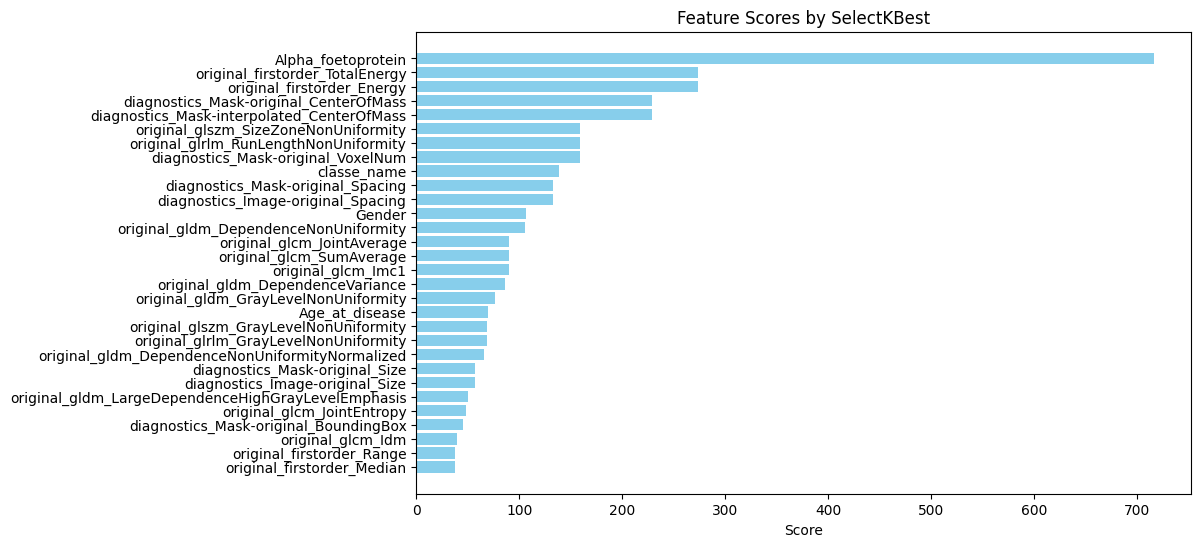

In [24]:
scores = selector.scores_[selector.get_support()]
feature_scores = pd.DataFrame({'Feature': selected_columns, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_scores['Feature'], feature_scores['Score'], color='skyblue')
plt.xlabel('Score')
plt.title('Feature Scores by SelectKBest')
plt.gca().invert_yaxis()
plt.show()

### Baseline Model

In [25]:
# Baseline
y_train_SMOTE.value_counts()

dead_after_one_year
0    5574
1    5574
Name: count, dtype: int64

## Model Benchmarks 
Here, we're simply running our models with no class adjustments and no hyper-parameter tuning. It's worth noting that <b>without feature engineering, our models performed substantially worse.</b> In iterations without feature engineering our Logistic Regression and AdaBoosting classifiers completely failed to identify any true positives.

In [26]:
init_list=[]

In [27]:
lr_1y = run_model('lr',mission='After one year')

### METRICS ###


{'model': 'lr',
 'mission': 'After one year',
 'train_auc': 0.8515147471428226,
 'test_auc': 0.8408463117929647,
 'precision': 0.3369214208826695,
 'specificity': 0.7422594142259414,
 'recall': 0.7245370370370371,
 'f_score': 0.4599559147685525}

True Negatives: 1774
False Positives: 616
False Negatives: 119
True Positives: 313


In [28]:
dt_1y = run_model('dt',mission='After one year')

### METRICS ###


{'model': 'dt',
 'mission': 'After one year',
 'train_auc': 1.0,
 'test_auc': 0.9874912831241284,
 'precision': 0.976905311778291,
 'specificity': 0.99581589958159,
 'recall': 0.9791666666666666,
 'f_score': 0.9780346820809248}

True Negatives: 2380
False Positives: 10
False Negatives: 9
True Positives: 423


In [29]:
rf_1y = run_model('rf',mission='After one year')

### METRICS ###


{'model': 'rf',
 'mission': 'After one year',
 'train_auc': 1.0,
 'test_auc': 1.0,
 'precision': 1.0,
 'specificity': 1.0,
 'recall': 0.9976851851851852,
 'f_score': 0.9988412514484357}

True Negatives: 2390
False Positives: 0
False Negatives: 1
True Positives: 431


In [30]:
gb_1y = run_model('gb',mission='After one year')

### METRICS ###


{'model': 'gb',
 'mission': 'After one year',
 'train_auc': 0.9997738616512233,
 'test_auc': 0.9995854641252131,
 'precision': 0.9704545454545455,
 'specificity': 0.9945606694560669,
 'recall': 0.9884259259259259,
 'f_score': 0.9793577981651376}

True Negatives: 2377
False Positives: 13
False Negatives: 5
True Positives: 427


In [31]:
et_1y = run_model('et',mission='After one year')

### METRICS ###


{'model': 'et',
 'mission': 'After one year',
 'train_auc': 1.0,
 'test_auc': 1.0,
 'precision': 1.0,
 'specificity': 1.0,
 'recall': 0.9976851851851852,
 'f_score': 0.9988412514484357}

True Negatives: 2390
False Positives: 0
False Negatives: 1
True Positives: 431


In [32]:
svc_1y = run_model('svc',mission='After one year')

### METRICS ###


{'model': 'svc',
 'mission': 'After one year',
 'train_auc': 0.9942951081633947,
 'test_auc': 0.9893867193553387,
 'precision': 0.7765567765567766,
 'specificity': 0.9489539748953975,
 'recall': 0.9814814814814815,
 'f_score': 0.8670756646216768}

True Negatives: 2268
False Positives: 122
False Negatives: 8
True Positives: 424


In [33]:
ada_1y = run_model('ada',mission='After one year')

c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


### METRICS ###


{'model': 'ada',
 'mission': 'After one year',
 'train_auc': 0.995283248420411,
 'test_auc': 0.9886026847977686,
 'precision': 0.8160469667318982,
 'specificity': 0.9606694560669456,
 'recall': 0.9652777777777778,
 'f_score': 0.8844114528101803}

True Negatives: 2296
False Positives: 94
False Negatives: 15
True Positives: 417


In [34]:
xg_1y = run_model('xgb',mission='After one year')

### METRICS ###


{'model': 'xgb',
 'mission': 'After one year',
 'train_auc': 1.0,
 'test_auc': 1.0,
 'precision': 1.0,
 'specificity': 1.0,
 'recall': 1.0,
 'f_score': 1.0}

True Negatives: 2390
False Positives: 0
False Negatives: 0
True Positives: 432


In [35]:
# Results of our initial modelling
pd.DataFrame(init_list).sort_values(by='test_auc', ascending=False).reset_index(drop=True)

,model,mission,train_auc,test_auc,precision,specificity,recall,f_score
0,rf,After one year,1.000000,1.000000,1.000000,1.000000,0.997685,0.998841
1,et,After one year,1.000000,1.000000,1.000000,1.000000,0.997685,0.998841
2,xgb,After one year,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,gb,After one year,0.999774,0.999585,0.970455,0.994561,0.988426,0.979358
4,svc,After one year,0.994295,0.989387,0.776557,0.948954,0.981481,0.867076
5,ada,After one year,0.995283,0.988603,0.816047,0.960669,0.965278,0.884411
6,dt,After one year,1.000000,0.987491,0.976905,0.995816,0.979167,0.978035
7,lr,After one year,0.851515,0.840846,0.336921,0.742259,0.724537,0.459956


In [36]:
y1_dict = {
    lr_1y: 'LogisticRegression',
    gb_1y: 'GradientBoostingClassifier',
    ada_1y: 'AdaBoostClassifier',
    rf_1y: 'RandomForest',
    svc_1y: 'SupportVectorMachineClf',
    et_1y: 'ExtraTreeClassifier',
    dt_1y: 'DecisionTreeClassifier',
    xg_1y:'XGBClassifier'
}

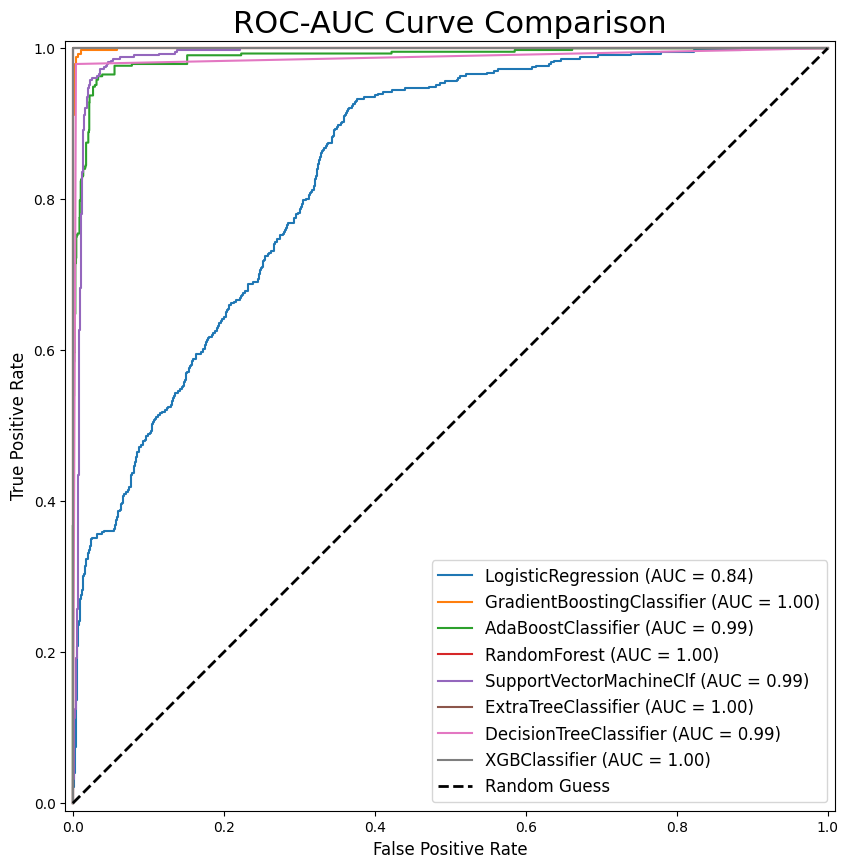

In [37]:
roc_curve_plotter(y1_dict)

### Hyperparameter selections

In [38]:
gs_list=[]

In [39]:
lr_params = {
    # Trying different types of regularization
    'lr__penalty':['l2','l1', 'elasticnet'],

     # Trying different alphas of: 1, 0.1, 0.05  (C = 1/alpha)
    'lr__C':[1, 10, 20],
}

In [40]:
lr_gs_1 = run_model('lr',lr_params, mission='After one year',grid_search=True)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
9 fits failed out of a total of 27.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.fit

### BEST PARAMS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'lr__C': 20, 'lr__penalty': 'l1'}

### METRICS ###


{'model': 'lr',
 'mission': 'After one year',
 'train_auc': 0.8521895895508506,
 'test_auc': 0.841128157446149,
 'precision': 0.3383947939262473,
 'specificity': 0.7447698744769874,
 'recall': 0.7222222222222222,
 'f_score': 0.4608567208271787}

True Negatives: 1780
False Positives: 610
False Negatives: 120
True Positives: 312


In [41]:
dt_params = {'dt__max_depth': [20, 30, 40, 50],
             'dt__min_samples_split': [2, 5, 10, 15],
             'dt__min_samples_leaf': [2, 3, 4, 5],
             'dt__class_weight': ['balanced']}

In [42]:
dt_gs_1 = run_model('dt',mod_params=dt_params,mission='After one year',grid_search=True)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
### BEST PARAMS ###


{'dt__class_weight': 'balanced',
 'dt__max_depth': 20,
 'dt__min_samples_leaf': 2,
 'dt__min_samples_split': 15}

### METRICS ###


{'model': 'dt',
 'mission': 'After one year',
 'train_auc': 0.999992371934435,
 'test_auc': 0.9905189446768944,
 'precision': 0.9767981438515081,
 'specificity': 0.99581589958159,
 'recall': 0.9745370370370371,
 'f_score': 0.9756662804171495}

True Negatives: 2380
False Positives: 10
False Negatives: 11
True Positives: 421


In [43]:
ada_params = {'ada__n_estimators': [500, 1000],
              'ada__learning_rate': [0.9, 1.0],
             }

In [44]:
ada_gs_1 = run_model('ada',mod_params=ada_params,mission='After one year',grid_search=True)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


### BEST PARAMS ###


{'ada__learning_rate': 1.0, 'ada__n_estimators': 1000}

### METRICS ###


{'model': 'ada',
 'mission': 'After one year',
 'train_auc': 1.0,
 'test_auc': 0.9967999380133272,
 'precision': 0.9839449541284404,
 'specificity': 0.997071129707113,
 'recall': 0.9930555555555556,
 'f_score': 0.988479262672811}

True Negatives: 2383
False Positives: 7
False Negatives: 3
True Positives: 429


In [45]:
gb_params = {'gb__n_estimators': [500, 1000],
             'gb__learning_rate': [0.4, 0.5, 0.6],
}

In [46]:
gb_gs_1 = run_model('gb',mod_params=gb_params,mission='After one year',grid_search=True)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
### BEST PARAMS ###


{'gb__learning_rate': 0.5, 'gb__n_estimators': 500}

### METRICS ###


{'model': 'gb',
 'mission': 'After one year',
 'train_auc': 1.0,
 'test_auc': 0.999998062916473,
 'precision': 0.9976851851851852,
 'specificity': 0.999581589958159,
 'recall': 0.9976851851851852,
 'f_score': 0.9976851851851852}

True Negatives: 2389
False Positives: 1
False Negatives: 1
True Positives: 431


In [47]:
et_params = {'et__n_estimators': [20, 25, 30, 35],
             'et__max_depth': [20, 30, 40, 50],
             'et__min_samples_leaf': [2, 3, 4],
            }

In [48]:
et_gs_1 = run_model('et',mod_params=et_params,mission='After one year',grid_search=True)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
### BEST PARAMS ###


{'et__max_depth': 20, 'et__min_samples_leaf': 2, 'et__n_estimators': 20}

### METRICS ###


{'model': 'et',
 'mission': 'After one year',
 'train_auc': 0.9999999999999999,
 'test_auc': 1.0,
 'precision': 1.0,
 'specificity': 1.0,
 'recall': 0.9884259259259259,
 'f_score': 0.9941792782305006}

True Negatives: 2390
False Positives: 0
False Negatives: 5
True Positives: 427


In [49]:
svc_params = {
    'svc__C':[10, 30],
    'svc__gamma':[0.01, 0.1], 
    'svc__kernel':['rbf', 'sigmoid'],
}

In [50]:
svc_gs_1 = run_model('svc',mod_params=svc_params,mission='After one year',grid_search=True)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


### BEST PARAMS ###


{'svc__C': 30, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}

### METRICS ###


{'model': 'svc',
 'mission': 'After one year',
 'train_auc': 1.0,
 'test_auc': 1.0,
 'precision': 1.0,
 'specificity': 1.0,
 'recall': 1.0,
 'f_score': 1.0}

True Negatives: 2390
False Positives: 0
False Negatives: 0
True Positives: 432


In [51]:
rf_params = {'rf__n_estimators': [20, 25, 30, 35],
             'rf__max_depth': [20, 30, 40, 50],
             'rf__min_samples_leaf': [2, 3, 4],
            }

In [52]:
rf_gs_1 = run_model('rf',mod_params=rf_params,mission='After one year',grid_search=True)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
### BEST PARAMS ###


{'rf__max_depth': 20, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 30}

### METRICS ###


{'model': 'rf',
 'mission': 'After one year',
 'train_auc': 1.0,
 'test_auc': 0.9999970943747094,
 'precision': 1.0,
 'specificity': 1.0,
 'recall': 0.9907407407407407,
 'f_score': 0.9953488372093023}

True Negatives: 2390
False Positives: 0
False Negatives: 4
True Positives: 428


In [53]:
pd.DataFrame(gs_list).sort_values(by=['test_auc','mission'], ascending=False).reset_index(drop=True)

,model,mission,train_auc,test_auc,precision,specificity,recall,f_score
0,et,After one year,1.000000,1.000000,1.000000,1.000000,0.988426,0.994179
1,svc,After one year,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,gb,After one year,1.000000,0.999998,0.997685,0.999582,0.997685,0.997685
3,rf,After one year,1.000000,0.999997,1.000000,1.000000,0.990741,0.995349
4,ada,After one year,1.000000,0.996800,0.983945,0.997071,0.993056,0.988479
5,dt,After one year,0.999992,0.990519,0.976798,0.995816,0.974537,0.975666
6,lr,After one year,0.852190,0.841128,0.338395,0.744770,0.722222,0.460857


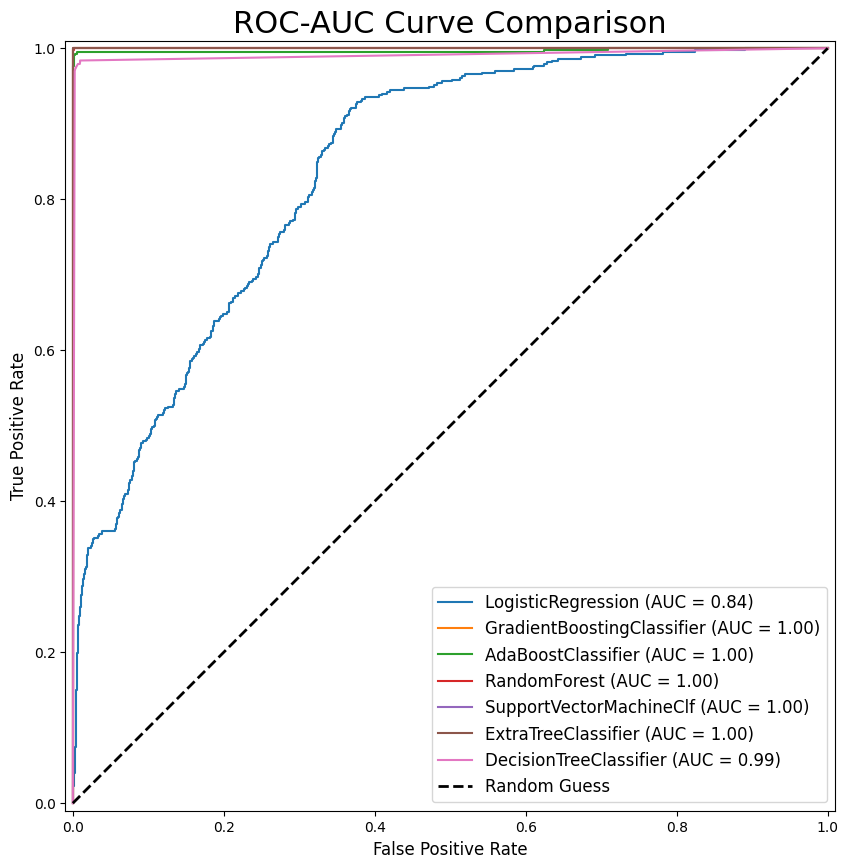

In [54]:
dict_hp_selected = {
    lr_gs_1: 'LogisticRegression',
    gb_gs_1: 'GradientBoostingClassifier',
    ada_gs_1: 'AdaBoostClassifier',
    rf_gs_1: 'RandomForest',
    svc_gs_1: 'SupportVectorMachineClf',
    et_gs_1: 'ExtraTreeClassifier',
    dt_gs_1: 'DecisionTreeClassifier',
}
roc_curve_plotter(dict_hp_selected)

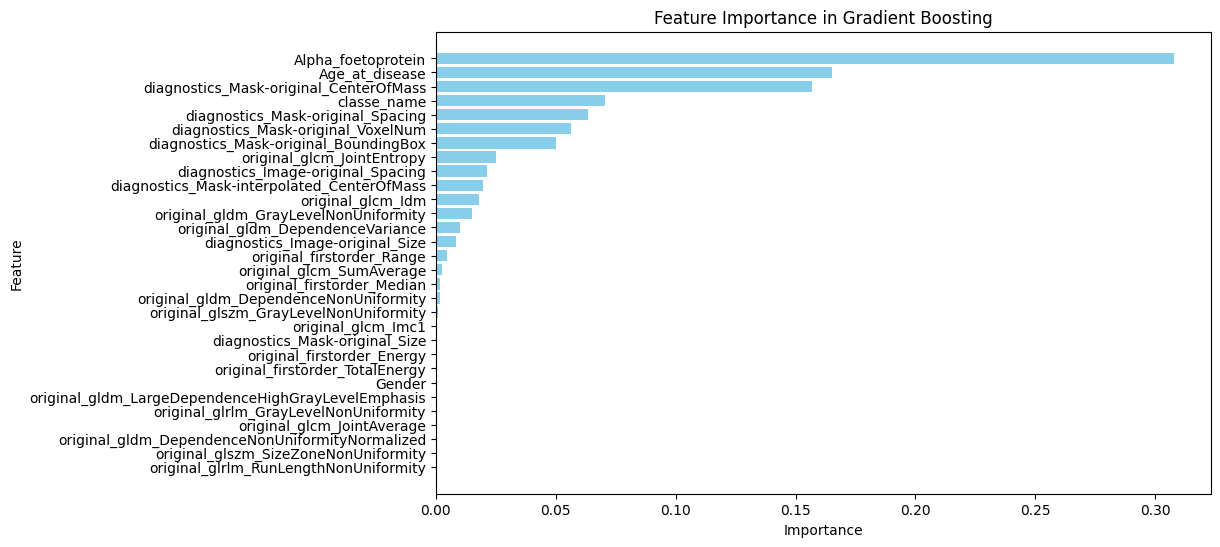

In [55]:
best_model = gb_gs_1.best_estimator_
feature_importances = best_model['gb'].feature_importances_  #feature_importances_
feature_names = X_train_selected_df.columns

feature_scores = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

feature_scores = feature_scores.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_scores['Feature'], feature_scores['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Gradient Boosting')
plt.gca().invert_yaxis()
plt.show()

### Six years

In [56]:
y = data['dead_after_six_year']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [20 33 38] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


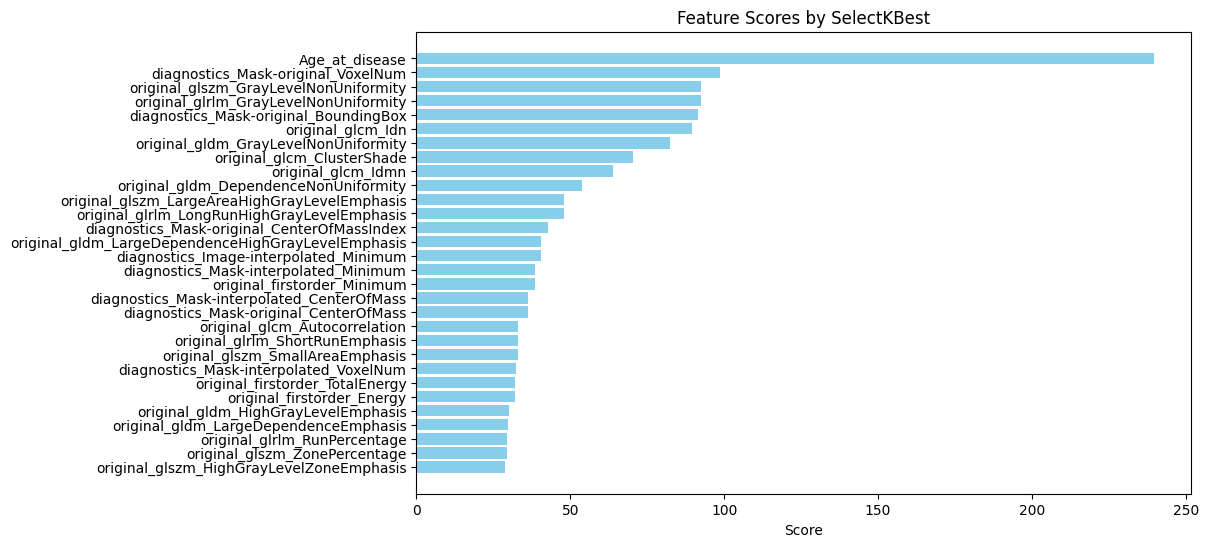

In [57]:
selector = SelectKBest(score_func=f_classif, k=30)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
selected_columns = X_original_col.columns[selector.get_support()]
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_columns,index=X_train.index)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_columns,index=X_test.index)
smote = SMOTE(random_state=42)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train_selected_df, y_train)

scores = selector.scores_[selector.get_support()]
feature_scores = pd.DataFrame({'Feature': selected_columns, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_scores['Feature'], feature_scores['Score'], color='skyblue')
plt.xlabel('Score')
plt.title('Feature Scores by SelectKBest')
plt.gca().invert_yaxis()
plt.show()

In [58]:
y_train_SMOTE.value_counts()

dead_after_six_year
0    4143
1    4143
Name: count, dtype: int64

In [59]:
init_list=[]
lr_6y = run_model('lr',mission='After six years')
dt_6y = run_model('dt',mission='After six years')
rf_6y = run_model('rf',mission='After six years')
gb_6y = run_model('gb',mission='After six years')
et_6y = run_model('et',mission='After six years')
svc_6y = run_model('svc',mission='After six years')
ada_6y = run_model('ada',mission='After six years')
xg_6y = run_model('xgb',mission='After six years')

### METRICS ###


{'model': 'lr',
 'mission': 'After six years',
 'train_auc': 0.7285917538046225,
 'test_auc': 0.7234165331679672,
 'precision': 0.5072992700729927,
 'specificity': 0.6199324324324325,
 'recall': 0.6644359464627151,
 'f_score': 0.5753311258278145}

True Negatives: 1101
False Positives: 675
False Negatives: 351
True Positives: 695
### METRICS ###


{'model': 'dt',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.9738089547482472,
 'precision': 0.9647619047619047,
 'specificity': 0.9791666666666666,
 'recall': 0.9684512428298279,
 'f_score': 0.9666030534351145}

True Negatives: 1739
False Positives: 37
False Negatives: 33
True Positives: 1013
### METRICS ###


{'model': 'rf',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.9998183233424629,
 'precision': 0.9961464354527938,
 'specificity': 0.9977477477477478,
 'recall': 0.988527724665392,
 'f_score': 0.9923224568138196}

True Negatives: 1772
False Positives: 4
False Negatives: 12
True Positives: 1034
### METRICS ###


{'model': 'gb',
 'mission': 'After six years',
 'train_auc': 0.9881611113761939,
 'test_auc': 0.9858241068506366,
 'precision': 0.8887876025524157,
 'specificity': 0.9313063063063063,
 'recall': 0.9321223709369025,
 'f_score': 0.9099393373775082}

True Negatives: 1654
False Positives: 122
False Negatives: 71
True Positives: 975
### METRICS ###


{'model': 'et',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.9997295036432227,
 'precision': 0.9951503394762367,
 'specificity': 0.9971846846846847,
 'recall': 0.9808795411089866,
 'f_score': 0.9879634087626384}

True Negatives: 1771
False Positives: 5
False Negatives: 20
True Positives: 1026
### METRICS ###


{'model': 'svc',
 'mission': 'After six years',
 'train_auc': 0.9322614725354714,
 'test_auc': 0.9210958090021186,
 'precision': 0.6884164222873901,
 'specificity': 0.7606981981981982,
 'recall': 0.8977055449330784,
 'f_score': 0.779253112033195}

True Negatives: 1351
False Positives: 425
False Negatives: 107
True Positives: 939


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


### METRICS ###


{'model': 'ada',
 'mission': 'After six years',
 'train_auc': 0.9240984082856374,
 'test_auc': 0.9113598242123576,
 'precision': 0.7455197132616488,
 'specificity': 0.8400900900900901,
 'recall': 0.7954110898661568,
 'f_score': 0.7696577243293247}

True Negatives: 1492
False Positives: 284
False Negatives: 214
True Positives: 832
### METRICS ###


{'model': 'xgb',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.9999930020843023,
 'precision': 0.9971374045801527,
 'specificity': 0.9983108108108109,
 'recall': 0.9990439770554493,
 'f_score': 0.9980897803247374}

True Negatives: 1773
False Positives: 3
False Negatives: 1
True Positives: 1045


In [60]:
# Results of our initial modelling
pd.DataFrame(init_list).sort_values(by=['test_auc','mission'], ascending=False).reset_index(drop=True)

,model,mission,train_auc,test_auc,precision,specificity,recall,f_score
0,xgb,After six years,1.000000,0.999993,0.997137,0.998311,0.999044,0.998090
1,rf,After six years,1.000000,0.999818,0.996146,0.997748,0.988528,0.992322
2,et,After six years,1.000000,0.999730,0.995150,0.997185,0.980880,0.987963
3,gb,After six years,0.988161,0.985824,0.888788,0.931306,0.932122,0.909939
4,dt,After six years,1.000000,0.973809,0.964762,0.979167,0.968451,0.966603
5,svc,After six years,0.932261,0.921096,0.688416,0.760698,0.897706,0.779253
6,ada,After six years,0.924098,0.911360,0.745520,0.840090,0.795411,0.769658
7,lr,After six years,0.728592,0.723417,0.507299,0.619932,0.664436,0.575331


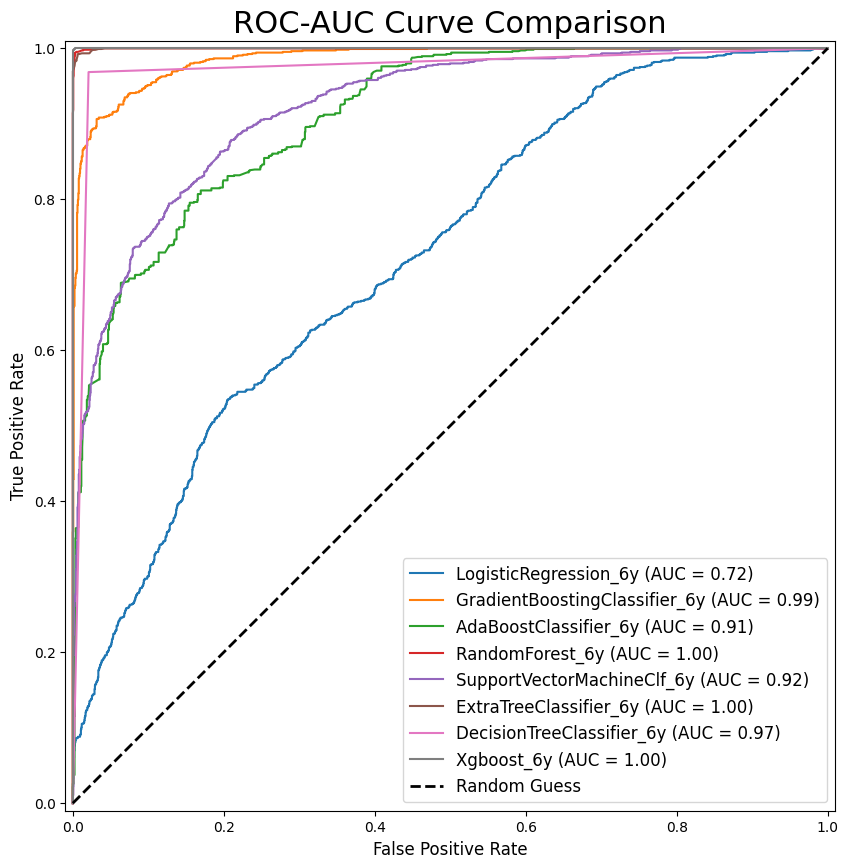

In [61]:
y6_dict = {
    lr_6y: 'LogisticRegression_6y',
    gb_6y: 'GradientBoostingClassifier_6y',
    ada_6y: 'AdaBoostClassifier_6y',
    rf_6y: 'RandomForest_6y',
    svc_6y: 'SupportVectorMachineClf_6y',
    et_6y: 'ExtraTreeClassifier_6y',
    dt_6y: 'DecisionTreeClassifier_6y',
    xg_6y:'Xgboost_6y'
}
roc_curve_plotter(y6_dict)

#### Hyperparameter selections

In [62]:
gs_list=[]

In [63]:
lr_params = {
    # Trying different types of regularization
    'lr__penalty':['l2','l1', 'elasticnet'],

     # Trying different alphas of: 1, 0.1, 0.05  (C = 1/alpha)
    'lr__C':[1, 10, 20],
}

In [64]:
lr_gs = run_model('lr',lr_params, mission='After six years',grid_search=True)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
9 fits failed out of a total of 27.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.fit

### BEST PARAMS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'lr__C': 20, 'lr__penalty': 'l2'}

### METRICS ###


{'model': 'lr',
 'mission': 'After six years',
 'train_auc': 0.7301052891357014,
 'test_auc': 0.7274376431881212,
 'precision': 0.5130624092888244,
 'specificity': 0.6221846846846847,
 'recall': 0.6759082217973231,
 'f_score': 0.5833333333333334}

True Negatives: 1105
False Positives: 671
False Negatives: 339
True Positives: 707


In [65]:
dt_params = {'dt__max_depth': [20, 30, 40, 50],
             'dt__min_samples_split': [1, 5, 10, 15],
             'dt__min_samples_leaf': [2, 3, 4, 5],
             'dt__class_weight': ['balanced']}

In [66]:
dt_gs = run_model('dt',mod_params=dt_params,mission='After six years',grid_search=True)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
48 fits failed out of a total of 192.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.

### BEST PARAMS ###


{'dt__class_weight': 'balanced',
 'dt__max_depth': 20,
 'dt__min_samples_leaf': 4,
 'dt__min_samples_split': 15}

### METRICS ###


{'model': 'dt',
 'mission': 'After six years',
 'train_auc': 0.9996272528177281,
 'test_auc': 0.9837844835753538,
 'precision': 0.9507575757575758,
 'specificity': 0.9707207207207207,
 'recall': 0.9598470363288719,
 'f_score': 0.9552806850618458}

True Negatives: 1724
False Positives: 52
False Negatives: 42
True Positives: 1004


In [67]:
ada_params = {'ada__n_estimators': [500, 1000],
              'ada__learning_rate': [0.9, 1.0],
             }

In [68]:
ada_gs = run_model('ada',mod_params=ada_params,mission='After six years',grid_search=True)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


### BEST PARAMS ###


{'ada__learning_rate': 1.0, 'ada__n_estimators': 1000}

### METRICS ###


{'model': 'ada',
 'mission': 'After six years',
 'train_auc': 0.9978926209632479,
 'test_auc': 0.9803229376604137,
 'precision': 0.9161230195712954,
 'specificity': 0.9493243243243243,
 'recall': 0.9397705544933078,
 'f_score': 0.927796130250118}

True Negatives: 1686
False Positives: 90
False Negatives: 63
True Positives: 983


In [69]:
gb_params = {'gb__n_estimators': [500, 1000],
             'gb__learning_rate': [0.4, 0.5, 0.6],
}

In [70]:
gb_gs = run_model('gb',mod_params=gb_params,mission='After six years',grid_search=True)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
### BEST PARAMS ###


{'gb__learning_rate': 0.6, 'gb__n_estimators': 1000}

### METRICS ###


{'model': 'gb',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.9999924637830947,
 'precision': 0.9971374045801527,
 'specificity': 0.9983108108108109,
 'recall': 0.9990439770554493,
 'f_score': 0.9980897803247374}

True Negatives: 1773
False Positives: 3
False Negatives: 1
True Positives: 1045


In [71]:
et_params = {'et__n_estimators': [20, 25, 30, 35],
             'et__max_depth': [20, 30, 40, 50],
             'et__min_samples_leaf': [2, 3, 4],
            }

In [72]:
et_gs = run_model('et',mod_params=et_params,mission='After six years',grid_search=True)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
### BEST PARAMS ###


{'et__max_depth': 30, 'et__min_samples_leaf': 2, 'et__n_estimators': 35}

### METRICS ###


{'model': 'et',
 'mission': 'After six years',
 'train_auc': 0.9999999999999999,
 'test_auc': 0.9991823204657813,
 'precision': 0.9863680623174295,
 'specificity': 0.9921171171171171,
 'recall': 0.9684512428298279,
 'f_score': 0.9773275446213218}

True Negatives: 1762
False Positives: 14
False Negatives: 33
True Positives: 1013


In [73]:
svc_params = {
    'svc__C':[10, 30],
    'svc__gamma':[0.01, 0.1], 
    'svc__kernel':['rbf', 'sigmoid'],
}

In [74]:
svc_gs = run_model('svc',mod_params=svc_params,mission='After six years',grid_search=True)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


### BEST PARAMS ###


{'svc__C': 30, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}

### METRICS ###


{'model': 'svc',
 'mission': 'After six years',
 'train_auc': 0.9987369533388459,
 'test_auc': 0.9889212228480873,
 'precision': 0.9484240687679083,
 'specificity': 0.9695945945945946,
 'recall': 0.9493307839388145,
 'f_score': 0.9488772097467749}

True Negatives: 1722
False Positives: 54
False Negatives: 53
True Positives: 993


In [75]:
rf_params = {'rf__n_estimators': [20, 25, 30, 35],
             'rf__max_depth': [20, 30, 40, 50],
             'rf__min_samples_leaf': [2, 3, 4],
            }

In [76]:
rf_gs = run_model('rf',mod_params=rf_params,mission='After six years',grid_search=True)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
### BEST PARAMS ###


{'rf__max_depth': 20, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 35}

### METRICS ###


{'model': 'rf',
 'mission': 'After six years',
 'train_auc': 0.9999999999999999,
 'test_auc': 0.9994170197922588,
 'precision': 0.9884726224783862,
 'specificity': 0.9932432432432432,
 'recall': 0.9837476099426387,
 'f_score': 0.9861044561571634}

True Negatives: 1764
False Positives: 12
False Negatives: 17
True Positives: 1029


In [77]:
pd.DataFrame(gs_list).sort_values(by=['test_auc','mission'], ascending=False).reset_index(drop=True)

,model,mission,train_auc,test_auc,precision,specificity,recall,f_score
0,gb,After six years,1.000000,0.999992,0.997137,0.998311,0.999044,0.998090
1,rf,After six years,1.000000,0.999417,0.988473,0.993243,0.983748,0.986104
2,et,After six years,1.000000,0.999182,0.986368,0.992117,0.968451,0.977328
3,svc,After six years,0.998737,0.988921,0.948424,0.969595,0.949331,0.948877
4,dt,After six years,0.999627,0.983784,0.950758,0.970721,0.959847,0.955281
5,ada,After six years,0.997893,0.980323,0.916123,0.949324,0.939771,0.927796
6,lr,After six years,0.730105,0.727438,0.513062,0.622185,0.675908,0.583333


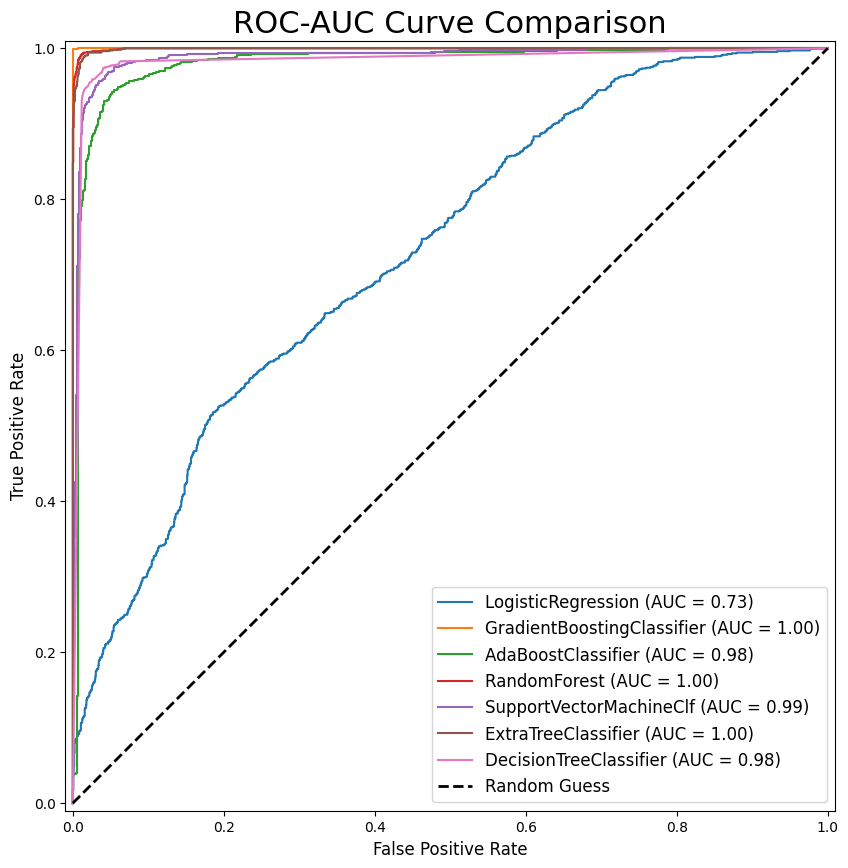

In [78]:
dict_hp_selected = {
    lr_gs: 'LogisticRegression',
    gb_gs: 'GradientBoostingClassifier',
    ada_gs: 'AdaBoostClassifier',
    rf_gs: 'RandomForest',
    svc_gs: 'SupportVectorMachineClf',
    et_gs: 'ExtraTreeClassifier',
    dt_gs: 'DecisionTreeClassifier',
}
roc_curve_plotter(dict_hp_selected)

In [79]:
best_model = dt_gs.best_estimator_
feature_importances = 






best_model['dt'].feature_importances_   #feature_importances_
feature_names = X_train_selected_df.columns

feature_scores = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

feature_scores = feature_scores.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_scores['Feature'], feature_scores['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Decision Tree')
plt.gca().invert_yaxis()
plt.show()


SyntaxError: invalid syntax (1647423992.py, line 2)